# Exploratory Analysis of Automobile Sales

The goal of this analysis is to break down the data of automobile sale listings and determine some of the factors that weigh into vehicle sales.

Some factors that will be looked into is the age, the milage, and the body type, and make/brand of different vehicles and how they impact pricing and sales.

Due to the limited nature of the information provided, we will be unable to see the impact that different trim levels, options, and aftermatket additions may play on vehicle pricing along with if a vehicle ended up being sold, or if the posting was modified prior to sale - whether the price was lowered, or more detail was added to increase appeal.

### Importing libraries and data

In [1]:
import streamlit as st
import pandas as pd
import plotly.express as px
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('moved_vehicles_us.csv')

### Overview of data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


In [4]:
df.head(10)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28
5,14990,2014.0,chrysler 300,excellent,6.0,gas,57954.0,automatic,sedan,black,1.0,2018-06-20,15
6,12990,2015.0,toyota camry,excellent,4.0,gas,79212.0,automatic,sedan,white,NaN,2018-12-27,73
7,15990,2013.0,honda pilot,excellent,6.0,gas,109473.0,automatic,SUV,black,1.0,2019-01-07,68
8,11500,2012.0,kia sorento,excellent,4.0,gas,104174.0,automatic,SUV,NaN,1.0,2018-07-16,19
9,9200,2008.0,honda pilot,excellent,NaN,gas,147191.0,automatic,SUV,blue,1.0,2019-02-15,17


### Preprocessing data

In [5]:
df['date_posted'] = pd.to_datetime(df['date_posted'], format='%Y-%m-%d') # Converting dates to datetime data type
df.isna().sum() # Getting a count of missing values by column

price               0
model_year       3619
model               0
condition           0
cylinders        5260
fuel                0
odometer         7892
transmission        0
type                0
paint_color      9267
is_4wd          25953
date_posted         0
days_listed         0
dtype: int64

In [6]:
# Checking for duplicates
df.duplicated().sum()

0

In [7]:
# Handling missing values in model_year
year_median = df['model_year'].median() # Finding the median year
df['model_year'] = df['model_year'].fillna(year_median) # Replacing the missing values with the median year
df = df.astype({'model_year':'int64'}) # Converting the column to the int64 data type

In [8]:
df['model_year'].isna().sum() # Verifying no more missing values

0

Missing values in `model_year` have been replaced with the median value rather than the average to reduce excessive deformation of the data in analysis.

In [9]:
# Handling missing values in cylinders
type_list = df['type'].unique() # Creating a list of body types
type_cyl_mode = df.groupby(['type'])['cylinders'].agg(pd.Series.mode) # Finding the mode cylinder for each type

In [10]:
type_cyl_mode

type
SUV             6.0
bus            10.0
convertible     8.0
coupe           8.0
hatchback       4.0
mini-van        6.0
offroad         6.0
other           6.0
pickup          8.0
sedan           4.0
truck           8.0
van             6.0
wagon           4.0
Name: cylinders, dtype: float64

In [11]:
cyl_four = ['hatchback', 'sedan', 'wagon']
cyl_six = ['SUV', 'mini-van', 'offroad', 'other', 'van']
cyl_eight = ['convertible', 'coupe', 'pickup', 'truck']
cyl_ten = ['bus']

In [12]:
df['cylinders'] = df[['cylinders']].where(~df['type'].isin(cyl_four), 4)
df['cylinders'] = df[['cylinders']].where(~df['type'].isin(cyl_six), 6)
df['cylinders'] = df[['cylinders']].where(~df['type'].isin(cyl_eight), 8)
df['cylinders'] = df[['cylinders']].where(~df['type'].isin(cyl_ten), 10)
df = df.astype({'cylinders':'int64'}) # Converting the column to the int64 data type

In [13]:
df['cylinders'].isna().sum() # Verifying no more missing values

0

Missing values in `cylinders` have been replaced with the mode, or most common value rather than the average to reflect the most popular cylinder count for engines overall. The mode of each body type was determined, then the appropriate modes were assigned to the missing values of vehicles with the same body types as to not skew the data based on the most common number of cylinders overall.

In [14]:
# Handling missing values in odometer
odometer_median = df['odometer'].median() # Finding the median odometer reading
df['odometer'] = df['odometer'].fillna(odometer_median) # Replacing the missing values with the median odometer reading
df = df.astype({'odometer':'int64'}) # Converting the column to the int64 data type

In [15]:
df['odometer'].isna().sum() # Verifying no more missing values

0

Just as with `model_year` the missing values of `odometer` have been replaced with the median value rather than the average to reduce excessive deformation of the data in analysis.

In [16]:
# Handling missing values in paint_color
df['paint_color'].value_counts(dropna=False) # Finding the counts of each unique value

white     10029
NaN        9267
black      7692
silver     6244
grey       5037
blue       4475
red        4421
green      1396
brown      1223
custom     1153
yellow      255
orange      231
purple      102
Name: paint_color, dtype: int64

In [17]:
df['paint_color'] = df['paint_color'].fillna('unspecified') # Replacing the missing values with 'unspecified'
df['paint_color'].value_counts(dropna=False) # Verifying the replaced missing values

white          10029
unspecified     9267
black           7692
silver          6244
grey            5037
blue            4475
red             4421
green           1396
brown           1223
custom          1153
yellow           255
orange           231
purple           102
Name: paint_color, dtype: int64

Missing values in `paint_color` have been replaced with 'unspecified' as the color is unknown and as the values are strings, indicating an unknown color could be more useful to future analysis.

In [18]:
# Handling missing values in is_4wd
df['is_4wd'].value_counts(dropna=False) # Getting a count of unique values

NaN    25953
1.0    25572
Name: is_4wd, dtype: int64

In [19]:
df['is_4wd'] = df['is_4wd'].fillna(0) # Replacing missing values with the value of zero
df = df.astype({'is_4wd':'int64'}) # Converting the column to the int64 data type
df['is_4wd'].value_counts(dropna=False) # Verifying there are no more missing values

0    25953
1    25572
Name: is_4wd, dtype: int64

The `is_4wd` column appears to contain the value of `1.0` if the vehicle was listed to have four wheel drive, and a missing value if not. This will be confirmed to get the unique values, including missing from this column, and if there are only the two aforementioned values, we will replace missing values with `0` (zero) and convert them to integers to act as a Bulian true or false, 1 = true, 0 = false. This doesn't mean that all the vehicles listed with a 0 (zero) do not have four wheel drive, but that they were not advertised to have it.

In [20]:
makemodel = df["model"].str.split(" ", n = 1, expand = True)
df['make'] = makemodel[0]
df['model'] = makemodel[1]
df.rename(columns={'model_year':'year', 'paint_color':'color'}, inplace=True)
df = df[['price', 'year', 'make', 'model', 'condition', 'cylinders', 'fuel','odometer', 'transmission', 'type', 'color', 'is_4wd', 'date_posted', 'days_listed']]

The vehicle model has been split to make and model, i.e. for a Honda Civic, the entire vehicle was stored together, and now there is a `make` column that would contain "honda" and a `model` column that would contain "civic" for the same vehicle. The columns have also been reordered for organizational purposes and some have been renamed for simplicity.

In [21]:
df.info() # Verifying data type for each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         51525 non-null  int64         
 1   year          51525 non-null  int64         
 2   make          51525 non-null  object        
 3   model         51525 non-null  object        
 4   condition     51525 non-null  object        
 5   cylinders     51525 non-null  int64         
 6   fuel          51525 non-null  object        
 7   odometer      51525 non-null  int64         
 8   transmission  51525 non-null  object        
 9   type          51525 non-null  object        
 10  color         51525 non-null  object        
 11  is_4wd        51525 non-null  int64         
 12  date_posted   51525 non-null  datetime64[ns]
 13  days_listed   51525 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(7)
memory usage: 5.5+ MB


In [22]:
df.isna().sum() # Verifying no missing values remain

price           0
year            0
make            0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
type            0
color           0
is_4wd          0
date_posted     0
days_listed     0
dtype: int64

### Streamlit coding for web app

In [23]:
st.header('Exploratory Analysis of Auto Listings')
st.write('''
The goal of this exploratory analysis is to use the interactive displays provided to assess trends and/or patterns relating to the listing of automobiles posted to be sold.
''')
st.write('''
Default display of vehicles only includes those listed for 30 days or less. In order to see all listings, including those listed for more than 30 days, click the checkbox below.
''')
old_listings = st.checkbox('Show cars listed over 30 days')

2023-02-27 12:24:27.339 
  command:

    streamlit run C:\Users\houle\anaconda3\envs\praktikum_sprint4\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [24]:
# Checkbox to include vehicles posted for over 30 days
if not old_listings:
    df_sl = df[df.days_listed<=30]

##### histogram for price(y) based on year(x) (slider for year)

In [25]:
# Selectbox for histogram
hist_list = ['condition', 'fuel', 'transmission', 'type', 'is_4wd']
hist_select = st.selectbox('Filter for average price', hist_list)

In [26]:
# Slider for year, limits then slider
min_year, max_year = int(df_sl['year'].min()), int(df_sl['year'].max())

year_range = st.slider(
    'Choose years',
    value=(min_year, max_year), min_value=min_year, max_value=max_year )

In [27]:
year_act_range = list(range(year_range[0],year_range[1]+1))
year_df = df_sl[(df_sl.year.isin(list(year_act_range)))]

In [28]:
fig1 = px.histogram(year_df, x='year', y='price', histfunc='avg', color=hist_select)

fig1.update_layout(title='<b>Average Price by Year</b>')

st.plotly_chart(fig1)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

##### scatterplot for odometer(y) based on price(x) (slider for price)

In [29]:
# Selectbox for scatterplot
scat_list = ['condition', 'fuel', 'transmission', 'type', 'is_4wd']
scat_select = st.selectbox('Filter for mileage by price', scat_list)

In [30]:
# Slider for price, limits then slider
min_price, max_price = int(df_sl['price'].min()), int(df_sl['price'].max())

price_range = st.slider(
    'Set price range',
    value=(min_price, max_price), min_value=min_price, max_value=max_price )

In [31]:
price_act_range = list(range(price_range[0],price_range[1]+1))
price_df = df_sl[(df_sl.price.isin(list(price_act_range)))]

In [32]:
fig2 = px.scatter(price_df, x='price', y='odometer', color=scat_select)

fig2.update_layout(title='<b>Mileage by Price (USD)</b>')

st.plotly_chart(fig2)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

##### boxplot for odometer (y) based on cylinders (slider of cylinders)

In [33]:
# Selectbox for box chart
box_list = ['condition', 'fuel', 'transmission', 'type', 'is_4wd']
box_select = st.selectbox('Filter for mileage by cylinder count', box_list)

In [34]:
# Slider of cylinders, limits then slider
min_cyl, max_cyl = int(df_sl['cylinders'].min()), int(df_sl['cylinders'].max())

cyl_range = st.slider(
    'Specify number of cylinders',
    value=(min_cyl, max_cyl), min_value=min_cyl, max_value=max_cyl )

In [35]:
cyl_act_range = list(range(cyl_range[0],cyl_range[1]+1))
cyl_df = df_sl[(df_sl.cylinders.isin(cyl_act_range))]

In [36]:
fig3 = px.box(cyl_df, x='cylinders', y='odometer', color=box_select)

fig3.update_layout(title='<b>Distribution of Mileage by Cylinder Count</b>')

st.plotly_chart(fig3)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

### Data Analysis

In [37]:
# Correlation between price and odometer reading - scatterplot

In [38]:
# Eliminating outliers from both odometer and price
odom_mean = df['odometer'].mean()
odom_sd = np.std(df['odometer'])
price_mean = df['price'].mean()
price_sd = np.std(df['price'])

# Creating condensed dataframe
df_scatter = df.query("(@odom_mean - @odom_sd*3) < odometer < (@odom_mean + @odom_sd*3)")[['price', 'odometer']]
df_scatter = df_scatter.query("(@price_mean - @price_sd*3) < price < (@price_mean + @price_sd*3)")

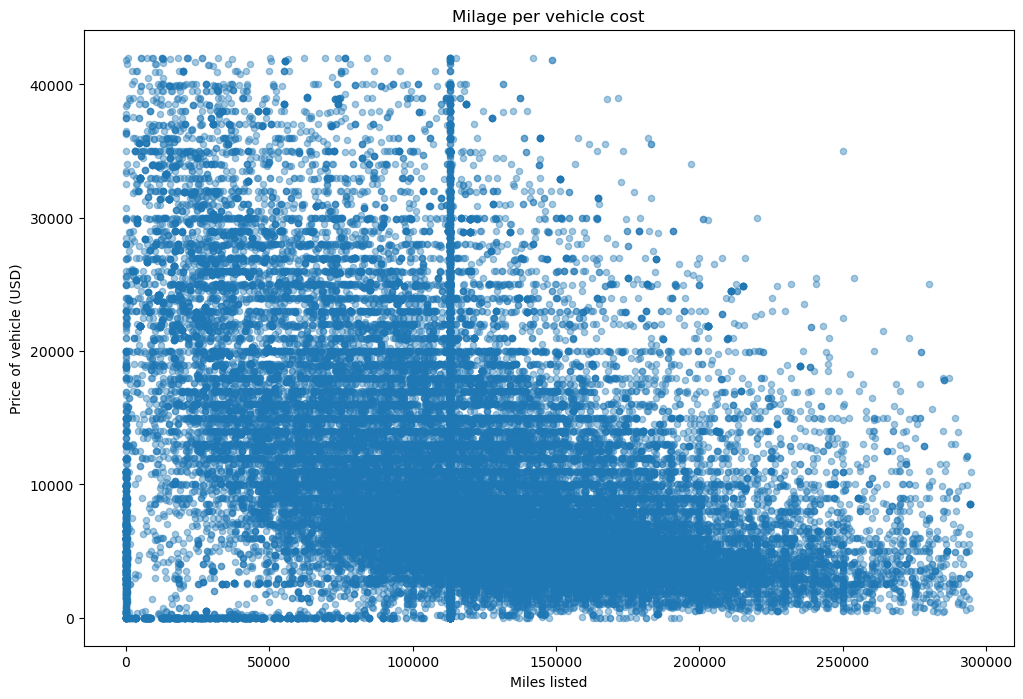

In [39]:
df_scatter.plot(kind='scatter',
                x= 'odometer',
                y= 'price',
                title= 'Milage per vehicle cost',
                xlabel= 'Miles listed',
                ylabel= 'Price of vehicle (USD)',
                figsize= [12,8],
                alpha= .4,
                legend=False
               )
plt.show()

In [40]:
display(df_scatter['price'].corr(df_scatter['odometer']))

-0.41337166567838357

There is a weak negative correlation between price and odometer/miles on the vehicle - this is illustrated by the scatter plot having a downward diagonal trend without solid definition and is confirmed when the Correlation Coefficient is calculated at -0.4133. This follows logic as vehicles with more use have deprecitaed in their value more than same or similar vehivles with less use. The correlation is only weak however due to the numerous other factors than milage that go into assessing a vehicle's value, such as overall condition, trim level of the vehicle, and other options that are included.

In [41]:
# Average price by year and vehicle type - bar

In [57]:
#Eliminating distant outliers in year
year_mean = df['year'].mean()
year_sd = np.std(df['year'])

# Creating condensed dataframe
df_bar = df.query("(@price_mean - @price_sd*3) < price < (@price_mean + @price_sd*3)")[['price', 'year', 'type']]
df_bar = df_bar.query("1960 <= year < (@year_mean + @year_sd*3)")
df_bar = df_bar.pivot_table(index='year',
                            values='price',
                            aggfunc='mean'
                           )

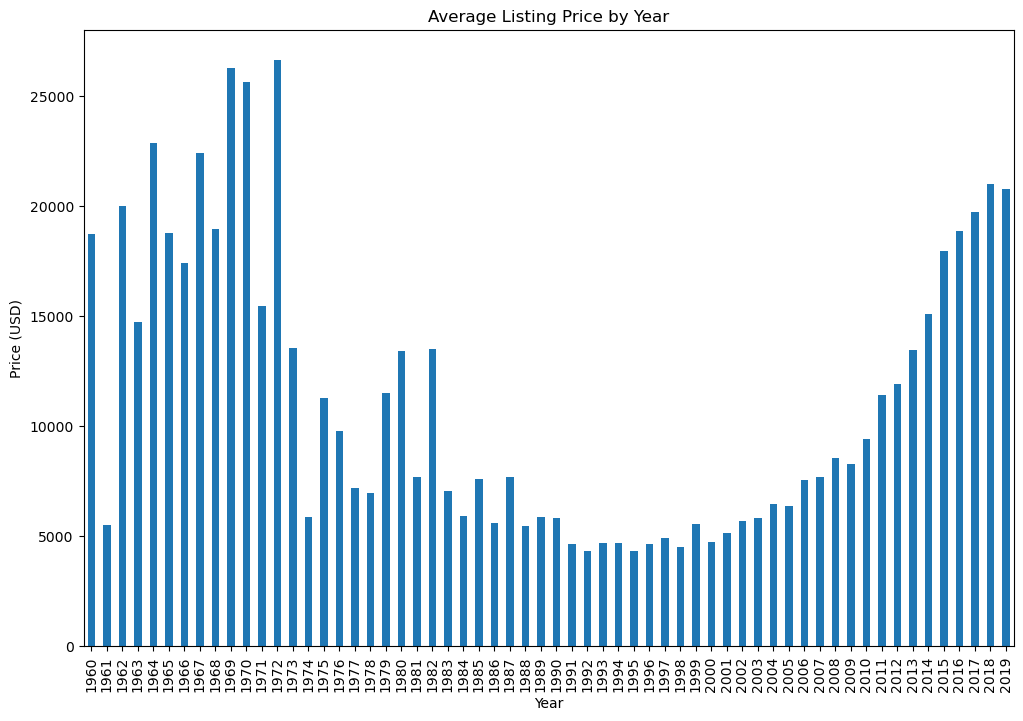

In [62]:
df_bar.plot(kind='bar',   
            title='Average Listing Price by Year', 
            xlabel='Year', ylabel='Price (USD)',
            figsize= [12,8],
            legend=False
           )
plt.show()

Unlike in the first graphic, the second illustrates the appreciation of value of "classic" and "vintage" cars well. As the average price of vehicles listed as made in the 1960's are similar, and in some cases exceeding those in the last three years, meaning the three most recent years and newest models. The illustration shows that older age of vehicles is not necessarily a negative factor to a vehicle's value - likely because as time progresses further from the year a vehicle is made, less and less exist in good condition making said vehicles more rare and desirable.

In [59]:
# Avearge price by make

In [85]:
# Creating condensed dataframe
df_bar2 = df.query("(@price_mean - @price_sd*3) < price < (@price_mean + @price_sd*3)")[['price', 'make', 'condition']]
conditions = ['new', 'like new', 'excellent', 'good']
df_bar2 = df_bar2[df_bar2['condition'].isin(conditions)]
df_bar2 = df_bar2.pivot_table(index='make',
                              columns='condition',
                              values='price',
                              aggfunc='mean'
                              )


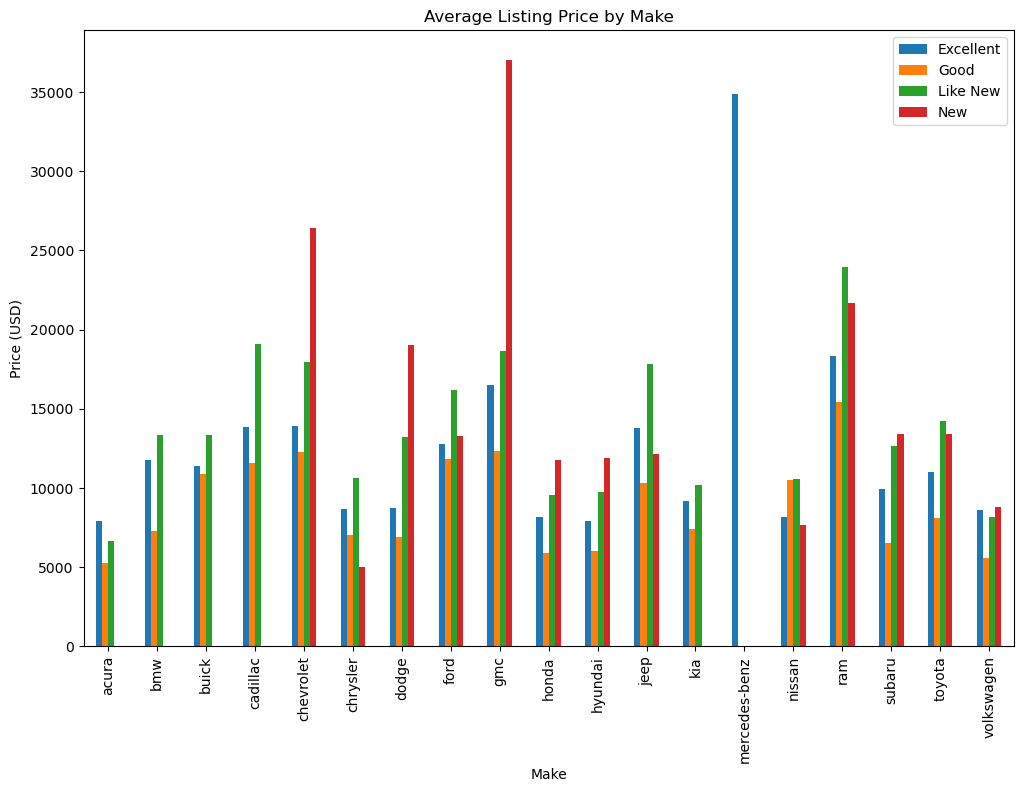

In [88]:
df_bar2.plot(kind='bar',   
             title='Average Listing Price by Make', 
             xlabel='Make', ylabel='Price (USD)',
             figsize= [12,8],
           )
plt.legend(['Excellent', 'Good', 'Like New', 'New'])
plt.show()

This graphic indicates that nomatter the condition, used vehicles don't vary to a great degree when they are of varying quality though there tends to be a logical depreciation to cost as condition level decreses. And even then, the different brands don't vary greatly from one another with two exceptions. The first being that Mercedes-Benz vehilces are valued high on average compared to other vehicle makes of excellent quality, even other "luxury" or "premium" brands like Acura, BMW, or Cadillac. The second is that Ram vehicles are comparitively higher value than the others, though this can be explained by no listed Ram vehicle being over ten years old, as the brand was created in 2010 and the oldest listed vehicle is made in 2019. This shifts older Ram trucks to be potentially listed as Dodge vehicles as Ram was a model designation before the brand was established.

In [67]:
df['condition'].unique()

array(['good', 'like new', 'fair', 'excellent', 'salvage', 'new'],
      dtype=object)

In [ ]:
# Vehicle type and days listed - boxplot

In [ ]:
# Creating condensed dataframe
df_box = df[['type', 'days_listed']]
df_box['type'].unique()
df_box = df_box.pivot(columns='type', values='days_listed')

In [ ]:
df_box.plot(kind='box', title='Distribution of Posting Duration', xlabel='Vehicle Type', ylabel='Days Listed for Sale',
            figsize= [12,8]
           )

In [ ]:
display(df['type'].value_counts())

For nearly all vehicle types, the average listing length is approximately 30 days, the only exception being bus which is a relatively small proportion comparted to other vehicle types. More popular vehicle types, which is confirmed by the `value_counts` indicates that those more common vehicle types tend to have more outliers extending beyond the 3rd quartile. This indicates that those more popular vehicles types including, but not limited to, SUV, truck, and sedan likely need to be priced more competitively to be sold in a timely manner compared to less popular types like bus, offroad, and other.

An alternate theory on why more popular vehicles have more outliers on listing lengths could be that with more vehicles representing certain body types, there are more vehicles owners that do not remove their sales postings after a period of time. However, without the proceedures and policies of the source of the information, exact reasons can not be determined with a great degree of accuracy.

### Summary of Findings

The exploratory analysis has indicated that there are numerous factors that go into the price of a vehicle listed for sale, as there were a number of patterns and correlations noted.

**Factors in vehicle price:** 

The age of vehicles tended towards the older the vehicle the lower the price, within thirty to fourty years. When vehicles older were put up for sale, they would then raise in price - likely due to "Classic" or "Vintage" vehicles being more rare, thus more desirable to obtain and possess, resulting in a higher value.

The milage of a vehicle had a weak negative correlation to the price - the logical reason that a stronger correlation was not found is that there are many more factors that go into a vehicle's value. Such as age, quality, make and model, trim level, options, and modifications. Due to the limited nature of the data, only a few of these factors could be looked at, but they support this conclusion.

The quality of the vehicle for sale impacts most every brand in the same way - the better the vehicle's condition, the better the price.

The brand of a vehicle determined a baseline for the average price which was then affected by the vehicle's quality. This can be explained by some brands having a higher or lower base price point than others which was then adjusted on vehicle condition.

**On listing lengths:**

It was found that more common vehicle types had more postings that extended beyond the upper quartiles range. This could be explained in one of two ways - either the market for a particular type of vehicle, being more saturated, created a more competitive market where properly priced vehicles were sold more quickly than others, or since there were more vehicles listed, there was a higher chance that sellers did not remove listings after a vehicle sold. That said, the less common the vehicle type, the less there were listings that existed too long beyond the average of approximately thirty days.